In [1]:
import pandas as pd
from SynTemp.SynUtils.utils import load_database
df = load_database('./Data/USPTO_50K/USPTO_50K_reactions.json.gz')

In [2]:
from SynTemp.SynProcessor.balance_checker import BalanceReactionCheck

check = BalanceReactionCheck(df, rsmi_column='reactions', n_jobs=1)
balance , unbalance = check.check_balances()

[17:09:35] WARNING: not removing hydrogen atom without neighbors
[17:09:35] WARNING: not removing hydrogen atom without neighbors
[17:09:35] WARNING: not removing hydrogen atom without neighbors
[17:09:35] WARNING: not removing hydrogen atom without neighbors
[17:09:35] WARNING: not removing hydrogen atom without neighbors
[17:09:35] WARNING: not removing hydrogen atom without neighbors
[17:09:35] WARNING: not removing hydrogen atom without neighbors
[17:09:35] WARNING: not removing hydrogen atom without neighbors
[17:09:35] WARNING: not removing hydrogen atom without neighbors
[17:09:35] WARNING: not removing hydrogen atom without neighbors
[17:09:35] WARNING: not removing hydrogen atom without neighbors
[17:09:35] WARNING: not removing hydrogen atom without neighbors
[17:09:35] WARNING: not removing hydrogen atom without neighbors
[17:09:35] WARNING: not removing hydrogen atom without neighbors
[17:09:35] WARNING: not removing hydrogen atom without neighbors
[17:09:35] WARNING: not r

In [3]:
from typing import List, Dict, Union
from rdkit import Chem
from joblib import Parallel, delayed


class ReactionProcessor:
    """
    A class for processing chemical reactions, including labeling and canonicalization
    of SMILES strings using RDKit.
    """

    @staticmethod
    def label_reactions(reaction_dict: Dict, id_column: str = "R-id", reaction_column: str = "reactions") -> Dict:
        """
        Labels chemical reactions based on their reactants, indicating whether they
        are oxidation or reduction reactions, and canonicalizes the SMILES strings.

        Parameters:
        - reaction_list (List[Dict]): A list of dictionaries, each representing a reaction
          with keys 'R-id' and 'new_reaction'.

        Returns:
        - List[Dict]: A list of dictionaries, each augmented with a 'label', 'reactants',
          and 'products' keys, where 'reactants' and 'products' are canonicalized SMILES.
        """

        label = "unspecified"
        r_id = reaction_dict.get("R-id", "N/A")
        new_reaction = reaction_dict.get(reaction_column, "")

        try:
            reactants, products = new_reaction.split(">>", 1)
        except ValueError:
            reactants, products = "", ""

        labeling_criteria = {
            ".[O]": "Oxidation",
            ".[H]": "Reduction",
        }

        for marker, reaction_label in labeling_criteria.items():
            if marker in reactants:
                label = reaction_label
                break

        reactants_smiles = Chem.CanonSmiles(reactants) if reactants else ""
        products_smiles = Chem.CanonSmiles(products) if products else ""

        new_dict = {
            id_column: r_id,
            reaction_column: new_reaction,
            "label": label,
            "reactants": reactants_smiles,
            "products": products_smiles,
        }

        return new_dict

    @classmethod
    def process_reactions_parallel(
        cls, reaction_list: List[Dict], n_jobs: int = -1
    ) -> List[Dict]:
        """
        Processes a list of chemical reactions in parallel, labeling them and
        canonicalizing their SMILES strings.

        Parameters:
        - reaction_list (List[Dict]): A list of dictionaries, each representing a reaction.
        - n_jobs (int): The number of jobs to run in parallel. -1 means using all processors.

        Returns:
        - List[Dict]: A processed list of reactions with labels and canonicalized SMILES.
        """
        results = Parallel(n_jobs=n_jobs)(
            delayed(cls.label_reactions)(reaction) for reaction in reaction_list
        )

        return results

    @staticmethod
    def calculate_charge(smiles: str) -> int:
        """
        Calculates the formal charge of a given molecule represented by a SMILES string.

        Parameters:
        - smiles (str): A SMILES string representing a molecule.

        Returns:
        - int: The formal charge of the molecule.
        """
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return 0  # Return 0 if the molecule cannot be parsed
        return Chem.rdmolops.GetFormalCharge(mol)

    @staticmethod
    def process_reaction(reaction: Dict[str, str]) -> Dict[str, Union[str, int]]:
        """
        Calculates and adds the total charge of products in a single reaction.

        Parameters:
        - reaction (Dict[str, str]): A dictionary representing a reaction with keys
          'R-id' and 'new_reaction'.

        Returns:
        - Dict[str, Union[str, int]]: The same reaction dictionary, with an added key
          'total_charge_in_products' indicating the sum of formal charges in its products.
        """
        products = reaction.get("products", "").split(".")
        total_charge = sum(
            ReactionProcessor.calculate_charge(product) for product in products
        )
        reaction["total_charge_in_products"] = total_charge
        return reaction

    @classmethod
    def sum_of_charge_in_products(
        cls, reaction_list: List[Dict], n_jobs: int = -1
    ) -> List[Dict]:
        """
        Calculates the sum of formal charges in the products of each reaction in the
        given list and adds this information to the reaction dictionaries.

        Parameters:
        - reaction_list (List[Dict]): A list of dictionaries, each representing a reaction.
        - n_jobs (int): The number of jobs to run in parallel. -1 means using all processors.

        Returns:
        - List[Dict]: The same list of reactions, with an added key 'total_charge_in_products'
          for each reaction, indicating the sum of formal charges in its products.
        """

        # Parallel processing of reactions to calculate the sum of charges in products
        processed_list = Parallel(n_jobs=n_jobs)(
            delayed(cls.process_reaction)(reaction) for reaction in reaction_list
        )

        return processed_list


In [4]:
from typing import Dict, Any, List
from joblib import Parallel, delayed


class UnbalancedCharge:
    @staticmethod
    def fix_negative_charge(
        reaction_dict: Dict[str, any], charges_column: str = "total_charge_in_products", 
        id_column: str = "R-id", reaction_column: str = "reactions"
    ) -> Dict[str, any]:
        """
        Adjusts a reaction dictionary to compensate for a negative charge in the products by adding [Na+] ions.

        This function calculates the number of sodium ions ([Na+]) needed to neutralize negative charges in the reaction products.
        It then adds the appropriate number of sodium ions to both the reactants and products.

        Args:
            reaction_dict (Dict[str, any]): A dictionary representing a chemical reaction. Must include keys for
                                            'total_charge_in_products', 'reactants', 'products', 'R-id', and 'label'.

        Returns:
            Dict[str, any]: A new reaction dictionary with adjusted reactants and products to neutralize the negative charge.
                            The 'total_charge_in_products' is set to 0, assuming the charge has been neutralized.
        """
        # Calculate the number of sodium ions to add based on the absolute value of total_charge_in_products
        num_na_to_add = abs(reaction_dict[charges_column])
        sodium_ion = "[Na+]"

        # Generate the string to add, with the correct number of sodium ions
        sodium_addition = (
            "." + ".".join([sodium_ion] * num_na_to_add) if num_na_to_add > 0 else ""
        )

        # Add the sodium ions to reactants and products
        new_reactants = reaction_dict["reactants"] + sodium_addition
        new_products = reaction_dict["products"] + sodium_addition

        # Generate the new reaction string
        new_reactions = new_reactants + ">>" + new_products

        # Create the new reaction dictionary
        new_reaction_dict = {
            id_column: reaction_dict["R-id"],
            reaction_column: new_reactions,
            "label": reaction_dict["label"],
            "reactants": new_reactants,
            "products": new_products,
            charges_column: 0,  # Assuming the charge is neutralized
        }

        return new_reaction_dict

    @staticmethod
    def fix_positive_charge(
        reaction_dict: Dict[str, any], charges_column: str = "total_charge_in_products",
        id_column: str = "R-id", reaction_column: str = "reactions"
    ) -> Dict[str, any]:
        """
        Adjusts a reaction dictionary to compensate for a positive charge in the products by adding [Cl-] ions. The function
        takes into account the total positive charge indicated in the reaction dictionary and adds an equivalent number of
        chloride ions ([Cl-]) to both reactants and products to neutralize the charge.

        Args:
            reaction_dict (Dict[str, any]): A dictionary representing a chemical reaction. This dictionary must include
                                            keys for reactants, products, and a specified charge column (default is
                                            'total_charge_in_products') which contains the total charge of the products.
            charges_column (str, optional): The key in `reaction_dict` that contains the total charge of the products.
                                            Defaults to 'total_charge_in_products'.

        Returns:
            Dict[str, any]: A modified reaction dictionary with added [Cl-] ions to neutralize the positive charge. The
                            'total_charge_in_products' is updated to 0, indicating that the reaction's charge has been
                            neutralized. The dictionary includes updated 'reactants', 'products', and a new reaction string.
        """
        # Calculate the number of chloride ions to add based on the positive total charge in the specified column
        num_cl_to_add = abs(reaction_dict[charges_column])
        chloride_ion = "[Cl-]"

        # Generate the string to add, with the correct number of chloride ions
        chloride_addition = (
            "." + ".".join([chloride_ion] * num_cl_to_add) if num_cl_to_add > 0 else ""
        )

        # Add the chloride ions to reactants and products
        new_reactants = reaction_dict["reactants"] + chloride_addition
        new_products = reaction_dict["products"] + chloride_addition

        # Generate the new reaction string
        new_reactions = new_reactants + ">>" + new_products

        # Create and return the new reaction dictionary with the neutralized charge
        new_reaction_dict = {
            id_column: reaction_dict[id_column],
            reaction_column: new_reactions,
            "label": reaction_dict["label"],
            "reactants": new_reactants,
            "products": new_products,
            charges_column: 0,  # Update the charge column to reflect the neutralized charge
        }

        return new_reaction_dict

    @staticmethod
    def fix_unbalanced_charged(
        reaction_dict: Dict[str, any], charges_column: str = "total_charge_in_products"
    ) -> Dict[str, any]:
        """
        Adjusts a reaction dictionary to compensate for an unbalanced charge in the products by adding either [Cl-] ions
        for a positive charge or [Na+] ions for a negative charge. The function determines the direction of the charge
        imbalance using the specified charges column and applies the appropriate correction.

        Args:
            reaction_dict (Dict[str, any]): A dictionary representing a chemical reaction. This dictionary must include
                                            keys for reactants, products, and a specified charge column which contains
                                            the total charge of the products.
            charges_column (str, optional): The key in `reaction_dict` that contains the total charge of the products.
                                            Defaults to 'total_charge_in_products'.

        Returns:
            Dict[str, any]: A modified reaction dictionary with added ions to neutralize the charge imbalance. The
                            returned dictionary will have its charge neutralized and include updated 'reactants',
                            'products', and a new reaction string. The specific ions added ([Cl-] for positive charges
                            or [Na+] for negative charges) depend on the initial charge imbalance.
        """
        if reaction_dict[charges_column] > 0:
            return UnbalancedCharge.fix_positive_charge(reaction_dict, charges_column)
        elif reaction_dict[charges_column] < 0:
            return UnbalancedCharge.fix_negative_charge(reaction_dict, charges_column)
        else:
            # If the charge is already balanced, return the original dictionary without modification.
            return reaction_dict

    @classmethod
    def parallel_fix_unbalanced_charge(
        cls,
        reaction_dicts: List[Dict[str, Any]],
        charges_column: str = "total_charge_in_products",
        n_jobs: int = -1,
    ) -> List[Dict[str, Any]]:
        """
        Processes a list of reaction dictionaries in parallel to compensate for unbalanced charges in the products,
        adding either [Cl-] ions for positive charges or [Na+] ions for negative charges.

        Args:
            reaction_dicts (List[Dict[str, Any]]): A list of dictionaries, each representing a chemical reaction that may have an unbalanced charge.
            charges_column (str): The key in each reaction dictionary that contains the total charge of the products. Defaults to 'total_charge_in_products'.
            n_jobs (int): The number of CPU cores to use for parallel processing. -1 means using all available cores.

        Returns:
            List[Dict[str, Any]]: A list of modified reaction dictionaries with charges neutralized, reflecting the addition of necessary ions.

        Note:
            This function requires the joblib library for parallel execution. Ensure joblib is installed and available for import.
        """
        # Use joblib.Parallel and joblib.delayed to parallelize the charge fixing
        fixed_reactions = Parallel(n_jobs=n_jobs)(
            delayed(cls.fix_unbalanced_charged)(reaction_dict, charges_column)
            for reaction_dict in reaction_dicts
        )
        return fixed_reactions


In [5]:
#from SynTemp.SynProcessor.reaction_processor import ReactionProcessor
#from SynTemp.SynProcessor.unbalanced_charge import UnbalancedCharge


labeled_list = ReactionProcessor.process_reactions_parallel(balance, n_jobs=4)
label_charge_list = ReactionProcessor.sum_of_charge_in_products(labeled_list, n_jobs=4)
fix_charge_balance = UnbalancedCharge.parallel_fix_unbalanced_charge(label_charge_list, charges_column='total_charge_in_products', n_jobs=4)

[17:09:53] WARNING: not removing hydrogen atom without neighbors
[17:09:53] WARNING: not removing hydrogen atom without neighbors
[17:09:53] WARNING: not removing hydrogen atom without neighbors
[17:09:53] WARNING: not removing hydrogen atom without neighbors
[17:09:53] WARNING: not removing hydrogen atom without neighbors
[17:09:53] WARNING: not removing hydrogen atom without neighbors
[17:09:53] WARNING: not removing hydrogen atom without neighbors
[17:09:53] WARNING: not removing hydrogen atom without neighbors
[17:09:53] WARNING: not removing hydrogen atom without neighbors
[17:09:53] WARNING: not removing hydrogen atom without neighbors
[17:09:53] WARNING: not removing hydrogen atom without neighbors
[17:09:53] WARNING: not removing hydrogen atom without neighbors
[17:09:53] WARNING: not removing hydrogen atom without neighbors
[17:09:53] WARNING: not removing hydrogen atom without neighbors
[17:09:53] WARNING: not removing hydrogen atom without neighbors
[17:09:53] WARNING: not r

In [9]:
reduction = [value for value in labeled_list if value['label'] == 'Reduction']

In [14]:
reduction[0]

{'R-id': 2,
 'reactions': 'CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2C(=O)OC[C@@H]2Cc2ccccc2)c2ccon2)cc1.[H].[H]>>CCN(CC)Cc1ccc(-c2nc(C)c(COc3ccc([C@H](CC(=O)N4C(=O)OC[C@@H]4Cc4ccccc4)c4ccon4)cc3)s2)cc1.O',
 'label': 'Reduction',
 'reactants': 'CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2C(=O)OC[C@@H]2Cc2ccccc2)c2ccon2)cc1.[H].[H]',
 'products': 'CCN(CC)Cc1ccc(-c2nc(C)c(COc3ccc([C@H](CC(=O)N4C(=O)OC[C@@H]4Cc4ccccc4)c4ccon4)cc3)s2)cc1.O'}

In [19]:
from fgutils import FGQuery
smiles = 'CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2C(=O)OC[C@@H]2Cc2ccccc2)c2ccon2)cc1.[H].[H]'
smiles_2 = 'CCN(CC)Cc1ccc(-c2nc(C)c(COc3ccc([C@H](CC(=O)N4C(=O)OC[C@@H]4Cc4ccccc4)c4ccon4)cc3)s2)cc1.O'
query = FGQuery(use_smiles=True)
fg1 = query.get(smiles)
fg2 = query.get(smiles_2)
print(fg1)
print(fg2)


[17:15:21] WARNING: not removing hydrogen atom without neighbors
[17:15:21] WARNING: not removing hydrogen atom without neighbors


[('amine', [2]), ('aldehyde', [13, 14]), ('ether', [20]), ('amide', [27, 28, 29]), ('carbamate', [29, 30, 31, 32])]
[('amine', [2]), ('ether', [16]), ('amide', [23, 24, 25]), ('carbamate', [25, 26, 27, 28]), ('alcohol', [48])]


[17:14:46] WARNING: not removing hydrogen atom without neighbors
[17:14:46] WARNING: not removing hydrogen atom without neighbors


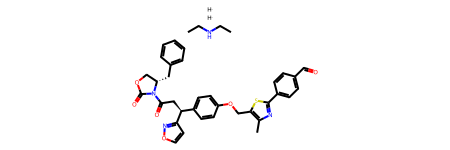

In [17]:
from rdkit import Chem
Chem.MolFromSmiles(smiles)

In [ ]:
self.fg = self.query.get(self.smiles)
        for dict in self.fg:
            if "hemiketal" in dict:
                atom_indices = dict[1]
                self.smiles = self.standardize_hemiketal(self.smiles, atom_indices)
                self.fg = self.query.get(self.smiles)
            elif "enol" in dict:
                atom_indices = dict[1]
                self.smiles = self.standardize_enol(self.smiles, atom_indices)
                self.fg = self.query.get(self.smiles)
        return Chem.CanonSmiles(self.smiles)

In [10]:
reduction

[{'R-id': 2,
  'reactions': 'CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2C(=O)OC[C@@H]2Cc2ccccc2)c2ccon2)cc1.[H].[H]>>CCN(CC)Cc1ccc(-c2nc(C)c(COc3ccc([C@H](CC(=O)N4C(=O)OC[C@@H]4Cc4ccccc4)c4ccon4)cc3)s2)cc1.O',
  'label': 'Reduction',
  'reactants': 'CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2C(=O)OC[C@@H]2Cc2ccccc2)c2ccon2)cc1.[H].[H]',
  'products': 'CCN(CC)Cc1ccc(-c2nc(C)c(COc3ccc([C@H](CC(=O)N4C(=O)OC[C@@H]4Cc4ccccc4)c4ccon4)cc3)s2)cc1.O'},
 {'R-id': 3,
  'reactions': 'CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NCC5CNC5)c([N+](=O)[O-])c4)c(Oc4cnc5[nH]ccc5c4)c3)CC2)=C(c2ccc(Cl)cc2)C1.O=C(CF)CF.[H].[H]>>CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NCC5CN(C(CF)CF)C5)c([N+](=O)[O-])c4)c(Oc4cnc5[nH]ccc5c4)c3)CC2)=C(c2ccc(Cl)cc2)C1.O',
  'label': 'Reduction',
  'reactants': 'CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NCC5CNC5)c([N+](=O)[O-])c4)c(Oc4cnc5[nH]ccc5c4)c3)CC2)=C(c2ccc(Cl)cc2)C1.O=C(CF)CF.[H].[H]',
  'products': 'CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NCC

In [ ]:
pd.DataFrame(fix_charge_balance)['total_charge_in_products'].value_counts()

In [ ]:
from SynTemp.SynProcessor.uncharge_reaction import UnchargeReaction
uncharge_fix = UnchargeReaction()
fix_charge_balance_post = uncharge_fix.apply_uncharge_smiles_to_reactions(fix_charge_balance, uncharge_fix.uncharge_smiles, n_jobs=4)

In [ ]:
pd.DataFrame(fix_charge_balance_post)['success'].value_counts()

In [ ]:
data = pd.DataFrame(fix_charge_balance_post)

data_fail = data[data['success'] == False]
data_fail

In [ ]:
from SynTemp.SynVis.chemical_reaction_visualizer import ChemicalReactionVisualizer
vis = ChemicalReactionVisualizer()
vis.visualize_reaction(data_fail.iloc[0]['reactions'], img_size=(1000, 500))

In [ ]:
from typing import List, Tuple, Callable, Dict
import random
from itertools import combinations, chain
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from itertools import permutations
from joblib import Parallel, delayed


class UnchargeReaction:
    """
    A class to uncharge the reactants and products of a reaction.
    """

    @staticmethod
    def mol_to_molecular_formula(mol):
        """
        Converts an RDKit molecule object to its molecular formula.

        Args:
        - mol (rdkit.Chem.Mol): An RDKit molecule object.

        Returns:
        - str: The molecular formula of the molecule.
        """
        return rdMolDescriptors.CalcMolFormula(mol)

    @staticmethod
    def random_pair_ions(
        charges: List[int], smiles: List[str]
    ) -> Tuple[List[List[str]], List[List[int]]]:
        """
        Generates non-overlapping groups of ions (2, 3, or 4) based on their charges and corresponding SMILES representations,
        aiming to maximize the total number of ions used by preferring multiple smaller groups over fewer larger groups.

        Args:
        - charges (List[int]): A list of integer charges of the ions.
        - smiles (List[str]): A list of SMILES strings representing the ions.

        Returns:
        - Tuple[List[List[str]], List[List[int]]]: A tuple containing two lists:
            - The first list contains the groups of SMILES strings.
            - The second list contains the groups of charges.
        """

        def find_groups(indices, size):
            """Finds and removes groups of a specific size that sum to zero charge."""
            for group in combinations(indices, size):
                if sum(charges[i] for i in group) == 0:
                    return group
            return []

        # Prepare initial variables
        indices = list(range(len(charges)))
        random.shuffle(indices)  # Shuffle indices to ensure variety
        used_indices = set()
        grouped_smiles = []
        grouped_charges = []

        # Attempt to form groups of varying sizes, prioritizing smaller groups first (2, 3, then 4)
        for group_size in range(
            2, 5
        ):  # Start with pairs, then triples, and finally quads
            while True:
                group = find_groups(
                    [i for i in indices if i not in used_indices], group_size
                )
                if not group:
                    break  # No more groups of this size can be formed
                grouped_smiles.append([smiles[i] for i in group])
                grouped_charges.append([charges[i] for i in group])
                used_indices.update(group)

        return grouped_smiles, grouped_charges

    @staticmethod
    def uncharge_anion(smiles: str, charges: int = -1) -> str:
        """
        Removes charge from an anionic species represented by a SMILES string.

        This function uses RDKit's standardization tools to neutralize the charges in the molecule.
        It returns the SMILES representation of the uncharged molecule.

        Args:
        - smiles (str): A SMILES string representing the anionic species.

        Returns:
        - str: The SMILES string of the uncharged molecule.

        Note:
        - The function assumes valid SMILES input.
        - The RDKit library must be installed and properly configured to use this function.
        """
        if smiles == "[N-]=[N+]=[N-]":
            return "[N-]=[N+]=[N]"
        if charges == -1:
            # Convert the SMILES string to an RDKit molecule object
            mol = Chem.MolFromSmiles(smiles)

            # Initialize the uncharger
            uncharger = rdMolStandardize.Uncharger()

            # Apply the uncharger to the molecule
            uncharged_mol = uncharger.uncharge(mol)

            # Convert the uncharged molecule back to a SMILES string
            return Chem.MolToSmiles(uncharged_mol)

        elif charges < -1:
            new_smiles = (
                smiles.replace(f"{charges}", "").replace("[", "").replace("]", "")
            )
            return new_smiles

    @staticmethod
    def uncharge_cation(smiles: str, charges: int = 1) -> str:
        """
        Removes charge from a cationic species represented by a SMILES string.

        This function uses RDKit's standardization tools to neutralize the charges in the molecule.
        It returns the SMILES representation of the uncharged molecule.

        Args:
        - smiles (str): A SMILES string representing the cationic species.

        Returns:
        - str: The SMILES string of the uncharged molecule.

        Note:
        - The function assumes valid SMILES input.
        - The RDKit library must be installed and properly configured to use this function.
        """
        # Special case handling or custom logic can be added here if needed

        if charges == 1:
            new_smiles = smiles.replace("+", "")
        elif charges > 1:
            # For multiple positive charges, directly modify the SMILES string
            new_smiles = smiles.replace(f"+{charges}", "")
        return new_smiles

    @staticmethod
    def uncharge_smiles(charge_smiles: str) -> str:
        """
        Processes a SMILES string containing ionic and non-ionic parts, neutralizes the charges, and returns a modified SMILES string.

        The function splits the input SMILES string into individual components, identifies ionic and non-ionic parts,
        and attempts to neutralize charged ions. It then creates permutations of the modified ions and combines them into
        a single SMILES string, ensuring the molecular structure is valid.

        Args:
        - charge_smiles (str): A SMILES string that may contain ionic and non-ionic parts.

        Returns:
        - str: A modified SMILES string with neutralized charges.

        Note:
        - This function depends on RDKit for molecular operations.
        - The function assumes a valid SMILES input.
        - The 'uncharge_anion' and 'random_pair_ions' functions must be defined and accessible.
        """

        smiles = charge_smiles.split(".")
        charges = [Chem.rdmolops.GetFormalCharge(Chem.MolFromSmiles(i)) for i in smiles]

        if all(charge == 0 for charge in charges):
            return charge_smiles

        valid_smiles, non_ionic_smiles = [], []
        original_ionic_parts, original_ion_charges = [], []

        # Splitting the SMILES into ionic and non-ionic parts
        for smile, charge in zip(smiles, charges):
            if charge == 0:
                non_ionic_smiles.append(smile)
            else:
                original_ionic_parts.append(smile)
                original_ion_charges.append(charge)

        valid_smiles.extend(non_ionic_smiles)
        paired_smiles, paired_charges = UnchargeReaction.random_pair_ions(
            original_ion_charges, original_ionic_parts
        )
        # Processing each pair of ionic parts
        for i_smile, i_charge in zip(paired_smiles, paired_charges):
            modified_ions = []
            for ion, charge in zip(i_smile, i_charge):
                if int(charge) > 0:
                    new_ion = UnchargeReaction.uncharge_cation(ion, charge)
                    modified_ions.append(new_ion)
                elif int(charge) < 0:
                    new_ion = UnchargeReaction.uncharge_anion(ion, charge)
                    modified_ions.append(new_ion)
            # Creating permutations of the modified ions
            check_merge = False
            for perm in permutations(modified_ions):
                combined_ionic = "".join(perm)
                if Chem.MolFromSmiles(combined_ionic):
                    coordinate_pattern = ["->", "<-"]
                    if all(
                        pattern not in Chem.CanonSmiles(combined_ionic)
                        for pattern in coordinate_pattern
                    ):
                        valid_smiles.append(Chem.CanonSmiles(combined_ionic))
                        check_merge = True
                        break
            if check_merge == False:
                valid_smiles.extend(i_smile)
        return ".".join(valid_smiles)

    @staticmethod
    def ammonia_hydroxide_standardize(reaction_smiles: str) -> str:
        """
        Replaces occurrences of ammonium hydroxide (NH4+ and OH-) in a reaction SMILES string with a simplified representation (N.O or O.N).

        Args:
            reaction_smiles (str): The reaction SMILES string to be standardized.

        Returns:
            str: The standardized reaction SMILES string with ammonium hydroxide represented as 'N.O' or 'O.N'.
        """
        # Simplify the representation of ammonium hydroxide in the reaction SMILES
        new_smiles = reaction_smiles.replace("[NH4+].[OH-]", "N.O").replace(
            "[OH-].[NH4+]", "O.N"
        )
        return new_smiles

    @classmethod
    def apply_uncharge_smiles_to_reactions(
        cls,
        reactions: List[Dict[str, str]],
        uncharge_smiles_func: Callable[[str], str],
        n_jobs: int = -1,
    ) -> List[Dict[str, str]]:
        """
        Applies a given uncharge SMILES function to the reactants and products of a list of chemical reactions,
        parallelizing the process for improved performance. Each reaction is expected to be a dictionary
        with at least 'reactants' and 'products' keys. The function adds three new keys to each reaction
        dictionary: 'uncharged_reactants', 'uncharged_products', and 'uncharged_reactions', containing
        the uncharged SMILES strings of reactants, products, and the overall reaction, respectively.

        Args:
            reactions (List[Dict[str, str]]): A list of dictionaries, where each dictionary represents
                a chemical reaction with 'reactants' and 'products' keys.
            uncharge_smiles_func (Callable[[str], str]): A function that takes a SMILES string as input
                and returns a modified SMILES string with neutralized charges.

        Returns:
            List[Dict[str, str]]: The input list of reaction dictionaries, modified in-place to include
                'uncharged_reactants', 'uncharged_products', and 'uncharged_reactions' keys.
        """

        # Define a helper function for processing a single reaction
        def process_reaction(reaction):
            fix_reactants = cls.ammonia_hydroxide_standardize(reaction["reactants"])
            fix_products = cls.ammonia_hydroxide_standardize(reaction["products"])

            uncharged_reactants = uncharge_smiles_func(fix_reactants)
            uncharged_products = uncharge_smiles_func(fix_products)
            uncharged_reactants_formula = cls.mol_to_molecular_formula(
                Chem.MolFromSmiles(uncharged_reactants)
            )
            uncharged_products_formula = cls.mol_to_molecular_formula(
                Chem.MolFromSmiles(uncharged_products)
            )
            if uncharged_reactants_formula != uncharged_products_formula:
                reaction["success"] = False
                reaction["new_reactants"] = fix_reactants
                reaction["new_products"] = fix_reactants
            else:
                reaction["success"] = True
                reaction["new_reactants"] = uncharged_reactants
                reaction["new_products"] = uncharged_products
            reaction["standardized_reactions"] = (
                f"{reaction['new_reactants']}>>{reaction['new_products']}"
            )
            return reaction

        # Use joblib to parallelize the processing of reactions
        reactions = Parallel(n_jobs=n_jobs)(
            delayed(process_reaction)(reaction) for reaction in reactions
        )
        return reactions
